In [24]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '1000'
environ['batch_norm']= 'True'
environ['loss_func']='MAPE'
environ['layers'] = '600 350 200 180'
environ['dropouts'] = '0.3 '*4
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:0'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [2]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

In [25]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion],
               callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                                        monitor='mape_criterion', min_delta=0, patience=50)])

if optimizer == 'SGD':
    l.opt_func = optim.SGD 
    

In [4]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [36]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


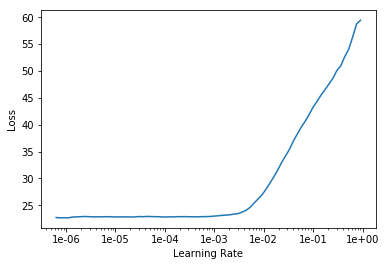

In [37]:
l.recorder.plot()

In [26]:
lr = 1e-03

In [27]:
l.fit_one_cycle(1000, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,131.186005,118.327110,118.327110,2.365730
2,111.737770,100.936920,100.936920,2.231269
3,102.769165,87.315552,87.315552,2.151950
4,100.130539,86.691376,86.691376,2.145351
5,98.921432,94.398590,94.398590,2.159111
6,97.031822,95.721207,95.721207,2.158938
7,94.874458,88.058144,88.058144,2.145090
8,94.225006,86.514900,86.514900,2.139602
9,92.927483,82.129356,82.129356,2.127649
10,91.896019,82.740257,82.740257,2.123766


Epoch 444: early stopping


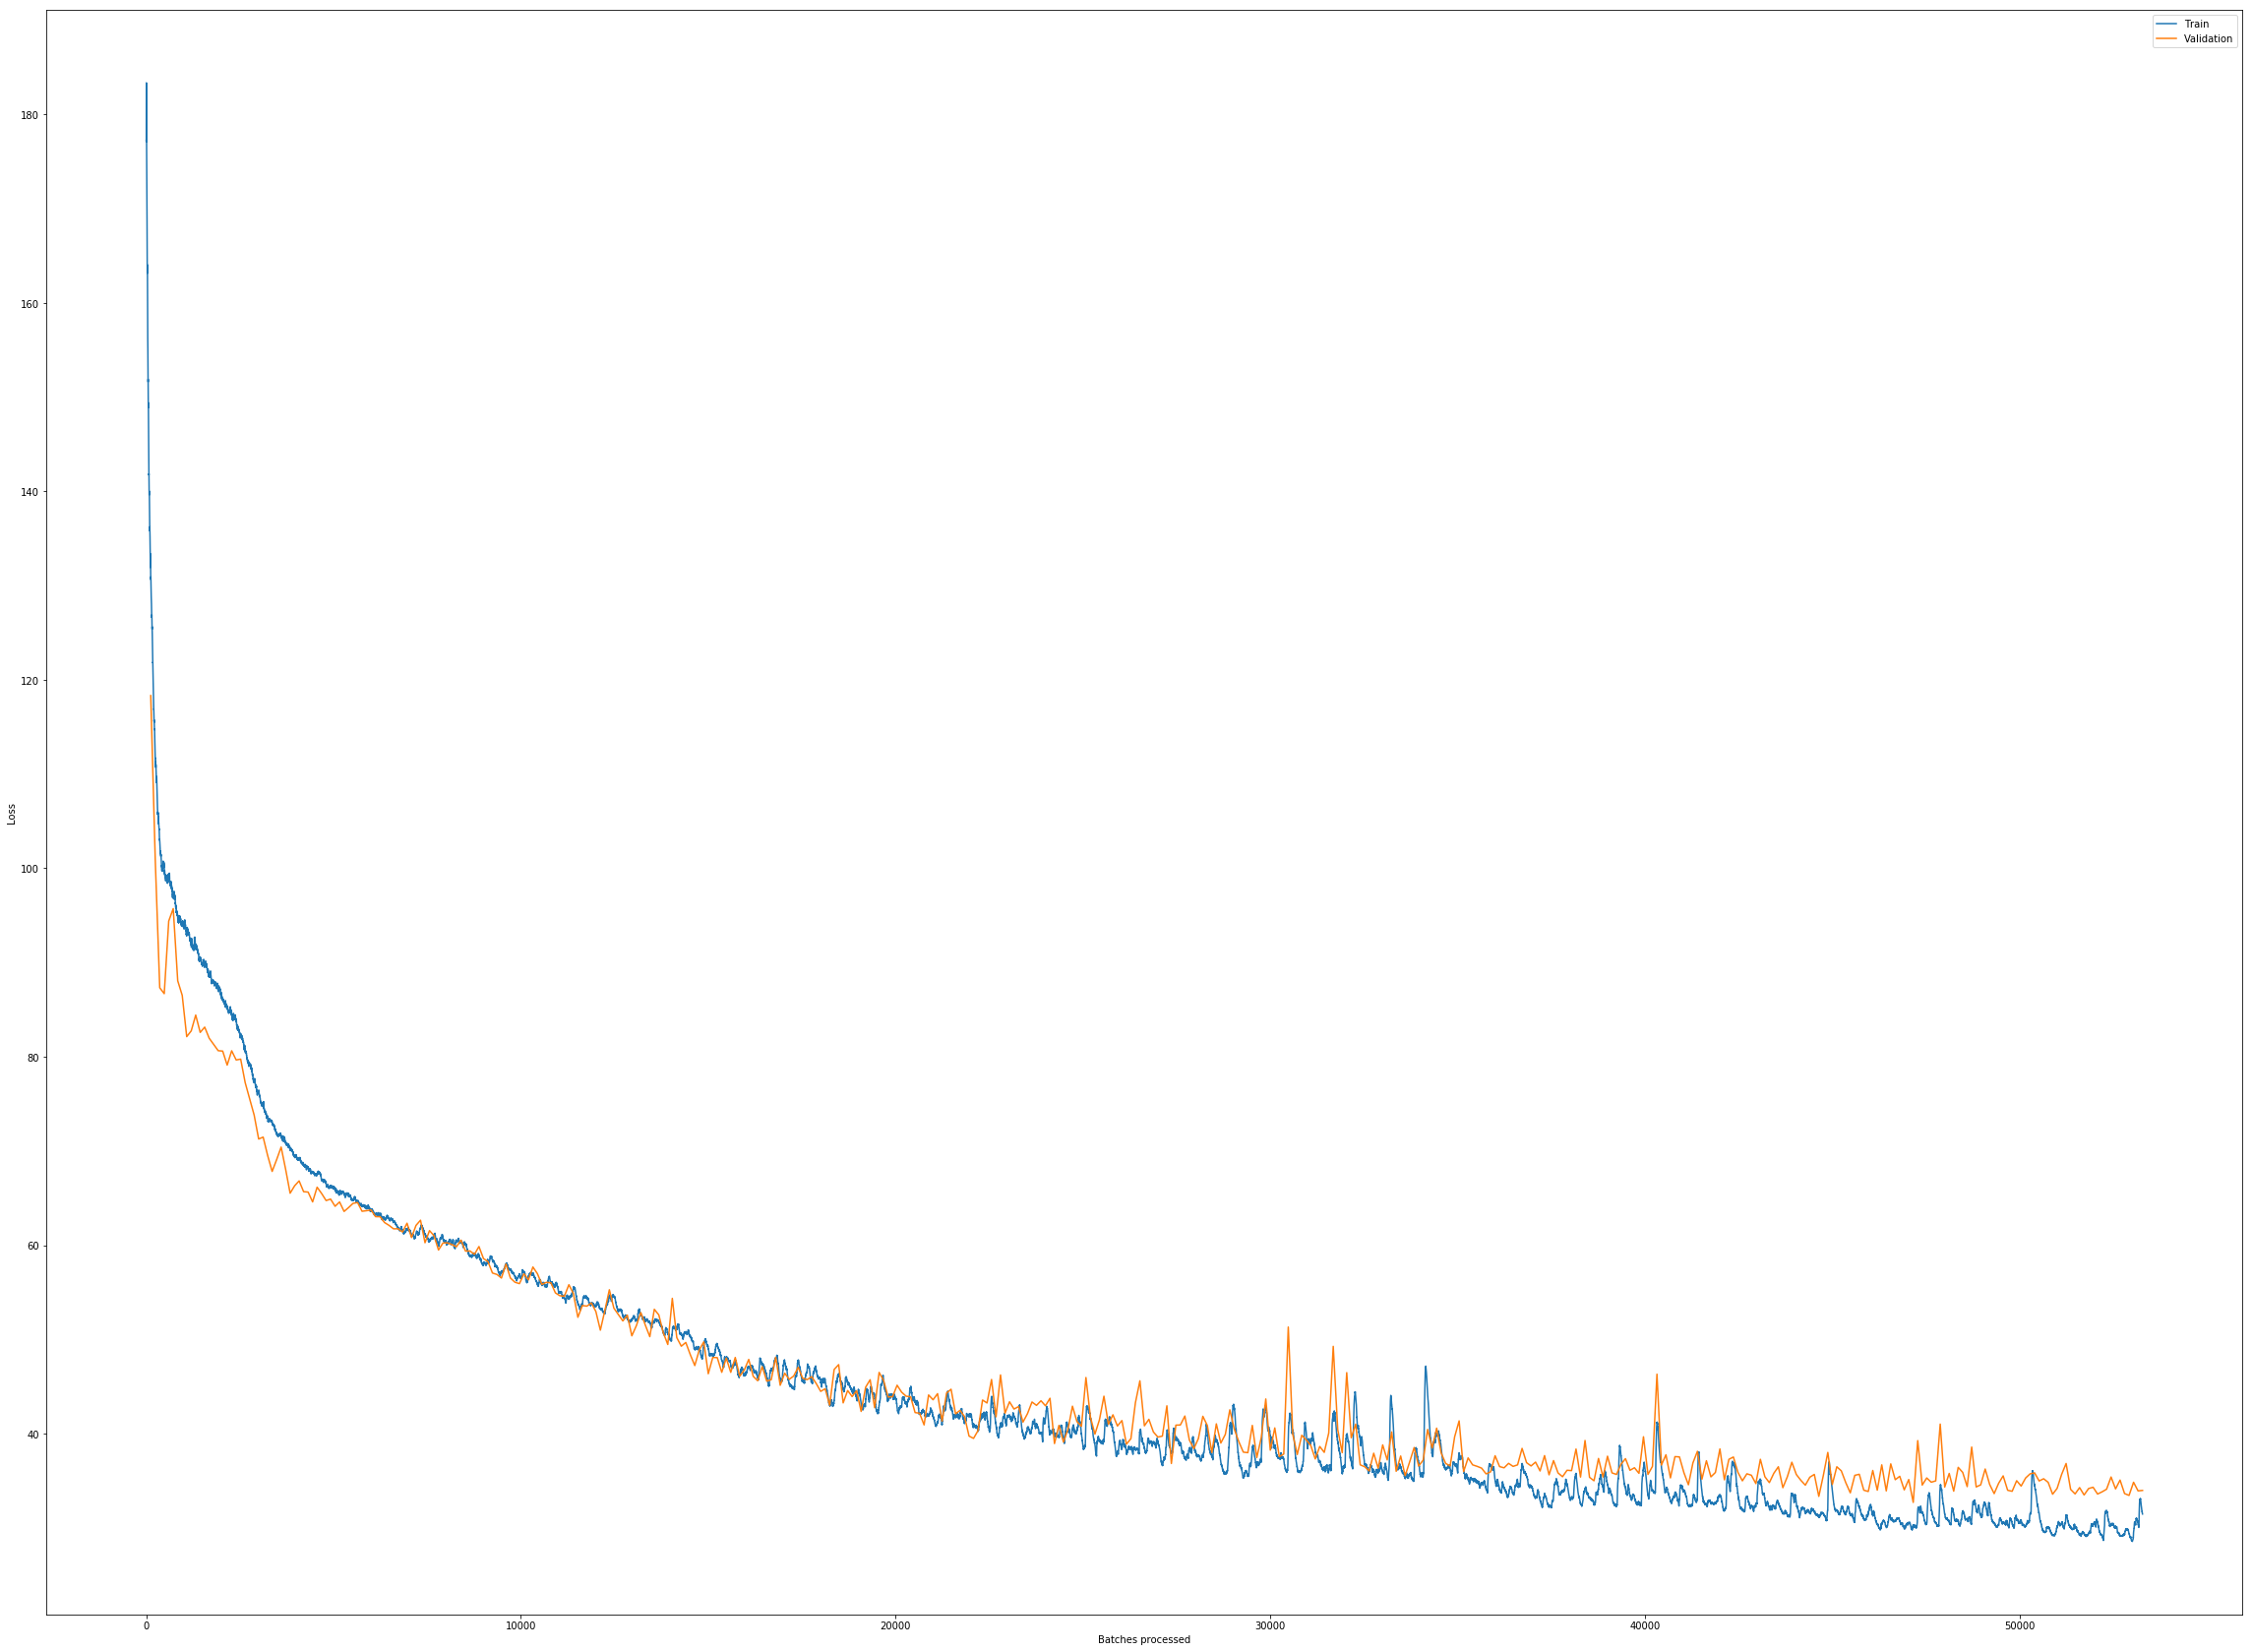

In [28]:
l.recorder.plot_losses()

In [114]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [9]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)

In [13]:
df = train_df

In [14]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,245283.000000,245283.000000,2.452830e+05,245283.000000
mean,0.973292,1.135724,2.070218e-01,15.228132
std,1.124538,1.405682,5.847120e-01,24.904913
min,0.012357,0.008491,3.352761e-07,0.000218
25%,0.243841,0.278690,7.342458e-03,1.289277
50%,0.794391,0.899071,3.170320e-02,8.011918
75%,0.994557,1.036481,1.367869e-01,18.878038
max,7.289485,16.089287,1.573884e+01,843.024414


In [144]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.340973,1.827336,0.608132,30.824635
std,1.507820,1.896899,0.946689,25.646006
min,0.016576,0.014435,0.000010,0.026734
25%,0.255195,0.400166,0.056756,10.030512
50%,0.731224,1.103367,0.202379,24.229412
75%,1.809107,2.574541,0.798606,45.231402
max,6.959387,11.454971,11.197384,352.485809


In [16]:
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,50406.000000,50406.0,50406.000000,50406.000000
mean,0.976389,1.0,0.025974,2.597483
std,0.129319,0.0,0.128854,12.885549
min,0.030101,1.0,0.000039,0.003862
25%,0.992063,1.0,0.005899,0.589913
50%,0.993235,1.0,0.006828,0.682819
75%,0.994147,1.0,0.008019,0.801933
max,5.496737,1.0,4.496737,449.673737


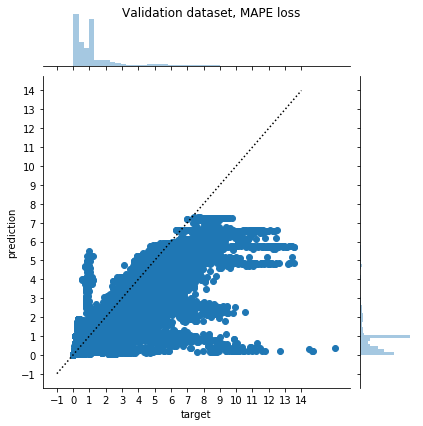

In [18]:
df1 = df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)]
#joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")

In [19]:
df_ = df.sort_values(by=["APE"])

df_['x'] = range(len(df_))

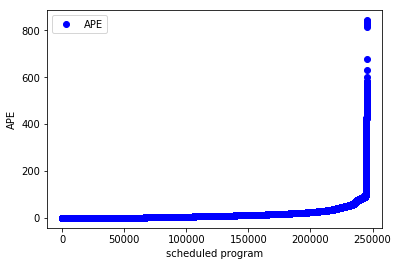

In [20]:
plt.plot('x', 'APE', 'bo', data=df_)


plt.xlabel('scheduled program')
plt.ylabel('APE')
plt.legend()

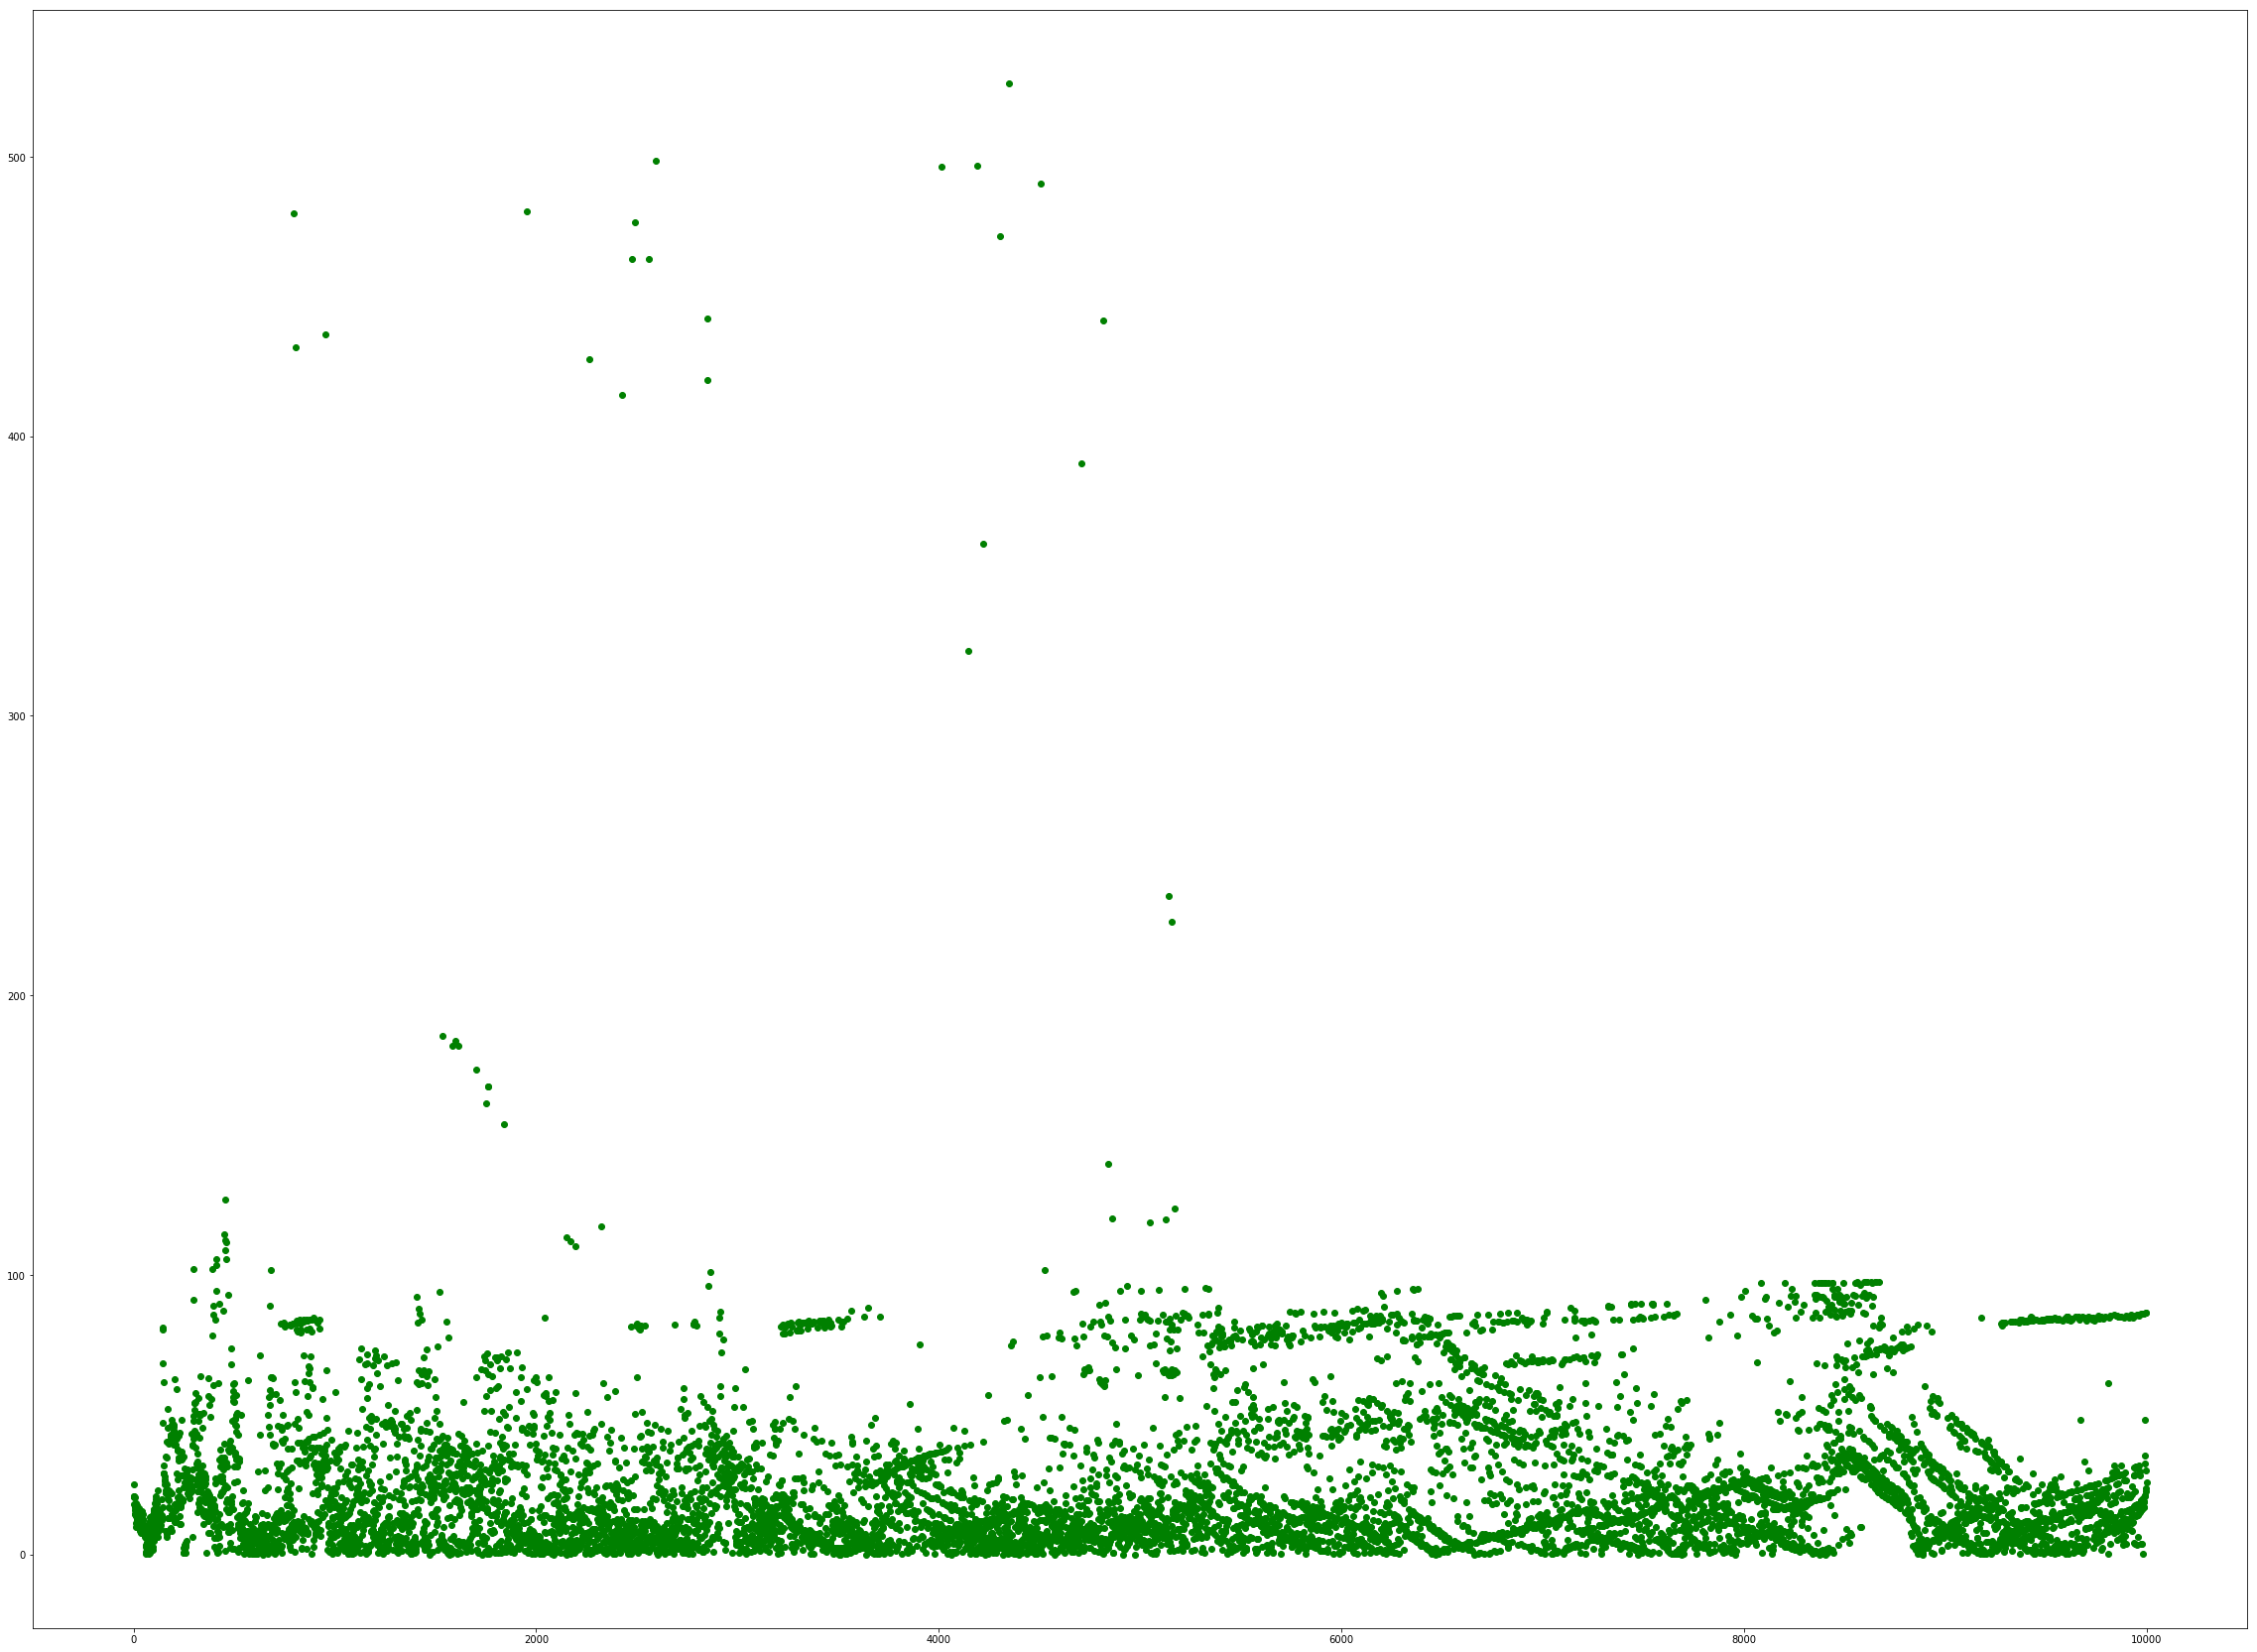

In [134]:
plt.plot('x', 'APE', 'go', data=df_)